<a href="https://colab.research.google.com/github/UFResearchComputing/gatorAI_summer_camp_2024/blob/main/01_full_of_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><img src="images/gator_ai_camp_2024_logo_200.png" align="right">

# Gator AI Summer Camp 2025

In this notebook, we're going to use Python to create a deep learning model that can take images of faces and output the emotion being expressed.

The dataset we're going to use is the FER-2013 dataset, which contains 35,887 grayscale images of faces. Each image is 48x48 pixels and is labeled with one of seven emotions: anger, disgust, fear, happiness, sadness, surprise, or neutral. The dataset and more information can be found [on Kaggle](https://www.kaggle.com/datasets/msambare/fer2013/data).

**Note:** One issue with the dataset is that it has relatively few images in the disgust category, so we drop that category for this exercise.

To build our model, we'll use the Keras deep learning library, which provides a high-level interface for building and training neural networks. We'll start by loading the dataset and exploring the images, then we'll build and train a convolutional neural network (CNN) to classify the emotions in the images.

**Before you get started, make sure to select a Runtime with a GPU!** <img src='images/colab_change_runtime_type.png' align='right' width='50%' alt='Image of the Runtime menu options in Google Colab'>
* Go to the **"Runtime"** menu
* Select **"Change runtime type"**
* Select **"T4 GPU"** and click **"Save"**

# 🎯 Learning Objectives & What You'll Build

## 🧠 What is Computer Vision?
Computer Vision is a field of AI that teaches computers to "see" and understand images, just like humans do! In this notebook, you'll build a system that can look at a person's face and automatically detect their emotion.

## 🎮 Real-World Application: Emotion-Aware Gaming
The emotion recognition model you'll create will be integrated into our adventure game, allowing Non-Player Characters (NPCs) to respond differently based on your facial expressions. Imagine:
- **Sad expression** → NPCs offer comfort and help
- **Happy expression** → NPCs share in your joy and give bonuses  
- **Angry expression** → NPCs try to calm you down
- **Surprised expression** → NPCs react to your amazement

## 📚 What You'll Learn Today

### 🔬 **Computer Vision Concepts**
- How computers "see" and process images
- What makes facial expressions recognizable
- Image preprocessing and data augmentation

### 🧠 **Deep Learning Fundamentals**
- **Convolutional Neural Networks (CNNs)** - the AI architecture that powers image recognition
- **Training Process** - how AI learns from thousands of examples
- **Model Evaluation** - measuring how well our AI performs

### 🛠️ **Practical Skills**
- Using **PyTorch Lightning** for efficient deep learning
- Working with real-world datasets (FER-2013 emotion dataset)
- Visualizing model performance and debugging
- Saving and loading trained models for deployment

### 🎮 **Game Integration**
- Loading pre-trained models in applications
- Real-time emotion detection from camera input
- Creating responsive NPC behavior based on emotions

## 🗺️ Our Journey Today

1. **📊 Data Exploration** - Understand our emotion dataset
2. **🏗️ Model Architecture** - Build our CNN emotion detector  
3. **🎓 Training Process** - Teach our AI to recognize emotions
4. **📈 Evaluation** - Test how well our model performs
5. **💾 Model Saving** - Prepare our model for the game
6. **🎮 Game Integration** - See how it works in practice

## 🚀 By the End of This Notebook

You'll have created a complete emotion recognition system that can:
- ✅ Detect 6 different emotions from facial expressions
- ✅ Work in real-time with camera input
- ✅ Integrate seamlessly with our adventure game
- ✅ Provide the foundation for emotion-aware applications

**Let's build the future of emotionally intelligent technology!** 🌟

In [1]:
# =============================================================================
# IMPORT LIBRARIES: The tools we need to build our emotion recognition system
# =============================================================================

# Basic Python libraries for file handling and data manipulation
import os                    # For working with files and directories
import sys                   # For system-specific operations
import shutil                # For copying and moving files
import zipfile               # For extracting zip archives
import random                # For generating random numbers
import pandas as pd          # For handling data in table format
import numpy as np           # For mathematical operations and arrays
import matplotlib.pyplot as plt  # For creating graphs and visualizations
from tqdm.auto import tqdm  # Progress bar library
import time

# Display plots directly in the notebook
%matplotlib inline           

# Additional utilities
from functools import reduce
import itertools
from collections import Counter
import kagglehub            # For downloading datasets from Kaggle
from PIL import Image # Import PIL Image for reliable image loading

# =============================================================================
# PYTORCH LIGHTNING: Our main deep learning framework
# =============================================================================
# PyTorch Lightning makes it easier to organize and train neural networks
# It handles a lot of the complex training logic for us!

import torch                           # Core PyTorch library
import torch.nn as nn                  # Neural network building blocks
import torch.nn.functional as F        # Common neural network functions
import torchvision                     # Computer vision utilities
import torchvision.transforms as transforms  # Image preprocessing tools
from torch.utils.data import DataLoader, Dataset  # Data loading utilities

import pytorch_lightning as pl         # Lightning framework for easier training
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# =============================================================================
# EVALUATION TOOLS: How we measure our model's performance
# =============================================================================
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

print("✅ All libraries imported successfully!")
print("🧠 Ready to build an emotion recognition system!")

c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


✅ All libraries imported successfully!
🧠 Ready to build an emotion recognition system!


In [2]:
# =============================================================================
# SMART DATA DOWNLOAD
# =============================================================================

print("🔍 Checking if emotion dataset already exists...")

# Check if we already have the data organized properly
data_exists = False
if os.path.exists("data"):
    train_dir = os.path.join("data", "train")
    test_dir = os.path.join("data", "test")

    if os.path.exists(train_dir) and os.path.exists(test_dir):
        # Check if we have emotion categories in both directories
        train_emotions = [
            d
            for d in os.listdir(train_dir)
            if os.path.isdir(os.path.join(train_dir, d))
        ]
        test_emotions = [
            d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))
        ]

        if (
            len(train_emotions) >= 5 and len(test_emotions) >= 5
        ):  # Should have at least 5 emotion categories
            print("✅ Dataset already exists and looks complete!")
            print(f"   Train emotions: {train_emotions}")
            print(f"   Test emotions: {test_emotions}")
            data_exists = True
        else:
            print("⚠️  Data directory exists but seems incomplete")
            print(f"   Train emotions found: {train_emotions}")
            print(f"   Test emotions found: {test_emotions}")

if not data_exists:
    print("📥 Dataset not found or incomplete. Downloading from Kaggle...")

    # Download the dataset using kagglehub
    print("Downloading dataset from Kaggle...")
    dataset_path = kagglehub.dataset_download("msambare/fer2013")
    print(f"Dataset downloaded to: {dataset_path}")

    # Create data directory if it doesn't exist
    if not os.path.exists("data"):
        os.makedirs("data")
        print("Created 'data' directory")

    # Check what files/folders are in the downloaded dataset
    print(f"Contents of {dataset_path}:")
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path):
            print(f"  Directory: {item}")
        else:
            print(f"  File: {item}")

    # Look for zip file first
    zip_file = None
    for file in os.listdir(dataset_path):
        if file.endswith(".zip"):
            zip_file = os.path.join(dataset_path, file)
            break

    if zip_file:
        # Extract the zip file to the data directory
        print(f"Extracting {zip_file} to data/")
        with zipfile.ZipFile(zip_file, "r") as zip_ref:
            zip_ref.extractall("data/")
        print("Extraction complete")
    else:
        # No zip file found, check if train/test directories already exist
        train_dir = os.path.join(dataset_path, "train")
        test_dir = os.path.join(dataset_path, "test")

        if os.path.exists(train_dir) and os.path.exists(test_dir):
            print("Found train and test directories, copying to data/")
            # Copy the train and test directories
            shutil.copytree(
                train_dir, os.path.join("data", "train"), dirs_exist_ok=True
            )
            shutil.copytree(test_dir, os.path.join("data", "test"), dirs_exist_ok=True)
            print("Directories copied successfully")
        else:
            # Look for any other structure
            print("Searching for dataset files in subdirectories...")
            for root, dirs, files in os.walk(dataset_path):
                if "train" in dirs and "test" in dirs:
                    train_source = os.path.join(root, "train")
                    test_source = os.path.join(root, "test")
                    print(f"Found train/test directories in: {root}")
                    shutil.copytree(
                        train_source, os.path.join("data", "train"), dirs_exist_ok=True
                    )
                    shutil.copytree(
                        test_source, os.path.join("data", "test"), dirs_exist_ok=True
                    )
                    print("Directories copied successfully")
                    break
            else:
                print("Could not find train/test directories in the downloaded dataset")

# Verify the final data directory structure
if os.path.exists("data"):
    print(f"\n📁 Final data directory structure:")
    for item in os.listdir("data"):
        item_path = os.path.join("data", item)
        if os.path.isdir(item_path):
            print(f"  Directory: {item}")
            # Show subdirectories (emotion categories) and count files
            if os.path.exists(item_path):
                subdirs = [
                    d
                    for d in os.listdir(item_path)
                    if os.path.isdir(os.path.join(item_path, d))
                ]
                print(f"    Emotion categories: {subdirs}")

                # Count total images
                total_images = 0
                for emotion_dir in subdirs:
                    emotion_path = os.path.join(item_path, emotion_dir)
                    image_files = [
                        f
                        for f in os.listdir(emotion_path)
                        if f.lower().endswith((".png", ".jpg", ".jpeg"))
                    ]
                    total_images += len(image_files)
                print(f"    Total images: {total_images}")

# Clean up disgust category (only if data was just downloaded or if disgust still exists)
disgust_train_path = os.path.join("data", "train", "disgust")
disgust_test_path = os.path.join("data", "test", "disgust")

disgust_removed = False
if os.path.exists(disgust_train_path):
    shutil.rmtree(disgust_train_path)
    print("\n🗑️  Removed data/train/disgust folder (too few examples)")
    disgust_removed = True

if os.path.exists(disgust_test_path):
    shutil.rmtree(disgust_test_path)
    print("🗑️  Removed data/test/disgust folder (too few examples)")
    disgust_removed = True

if not disgust_removed:
    print("\n✅ Disgust category already removed or not present")

print("\n🎉 Dataset preparation complete!")

🔍 Checking if emotion dataset already exists...
✅ Dataset already exists and looks complete!
   Train emotions: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
   Test emotions: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

📁 Final data directory structure:
  Directory: test
    Emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    Total images: 7067
  Directory: train
    Emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    Total images: 7067
  Directory: train
    Emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    Total images: 28273

✅ Disgust category already removed or not present

🎉 Dataset preparation complete!
    Total images: 28273

✅ Disgust category already removed or not present

🎉 Dataset preparation complete!


In [3]:
# =============================================================================
# CUSTOM DATASET CLASS: Teaching the computer how to read our emotion images
# =============================================================================


class EmotionDataset(Dataset):
    """
    This class teaches PyTorch how to load and process our emotion images.
    Think of it as a recipe that tells the computer:
    1. Where to find each image
    2. What emotion label goes with each image
    3. How to prepare the image for our neural network
    """

    def __init__(self, root_dir, transform=None):
        """
        Initialize our dataset
        - root_dir: folder containing our emotion images
        - transform: image preprocessing steps (resize, normalize, etc.)
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []

        # Find all emotion categories (angry, happy, sad, etc.)
        emotion_folders = sorted(
            [
                f
                for f in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, f))
            ]
        )
        self.class_names = emotion_folders

        print(f"📂 Found emotion categories: {self.class_names}")

        # Load all image paths and their corresponding emotion labels
        for label_idx, emotion in enumerate(emotion_folders):
            emotion_path = os.path.join(root_dir, emotion)

            # Count images in this emotion category
            image_files = [
                f
                for f in os.listdir(emotion_path)
                if f.lower().endswith((".png", ".jpg", ".jpeg"))
            ]
            print(f"   {emotion}: {len(image_files)} images")

            # Add each image path and its label to our lists
            for img_file in image_files:
                self.images.append(os.path.join(emotion_path, img_file))
                self.labels.append(label_idx)

        print(f"📊 Total dataset size: {len(self.images)} images")

    def __len__(self):
        """Return the total number of images in our dataset"""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Get a single image and its label
        This function is called each time we want to train on one image
        """
        # Load the image
        img_path = self.images[idx]
        image = plt.imread(img_path)

        # Convert to grayscale if needed (emotion recognition works well with grayscale)
        if len(image.shape) == 3:
            image = np.mean(image, axis=2)

        # Convert to PyTorch tensor format
        image = torch.FloatTensor(image).unsqueeze(0)  # Add channel dimension

        # Apply preprocessing transformations
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


# =============================================================================
# PYTORCH LIGHTNING DATA MODULE: Organizing our data for training
# =============================================================================


class EmotionDataModule(pl.LightningDataModule):
    """
    This class handles all our data loading and preprocessing.
    Lightning Data Modules keep our data code organized and reusable!
    """

    def __init__(self, data_dir, batch_size=32, img_size=80, num_workers="auto"):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size

        # Auto-detect optimal number of workers based on platform
        if num_workers == "auto":
            if os.name == "nt":  # Windows
                self.num_workers = 0  # Avoid multiprocessing issues on Windows
                print("🪟 Windows detected: Using single-threaded data loading")
            else:  # Linux/Mac
                import multiprocessing

                self.num_workers = min(
                    4, multiprocessing.cpu_count()
                )  # Cap at 4 for stability
                print(f"🐧 Unix-like system detected: Using {self.num_workers} workers")
        else:
            self.num_workers = num_workers
            print(f"🔧 Manual worker count: {self.num_workers}")

        # Define comprehensive image preprocessing steps
        # These help our model work better and prevent overfitting
        self.train_transform = transforms.Compose(
            [
                transforms.Resize(
                    (img_size, img_size)
                ),  # Resize all images to same size
                transforms.RandomHorizontalFlip(
                    p=0.5
                ),  # Random horizontal flip for data augmentation
                transforms.RandomRotation(10),  # Slight rotation for robustness
                transforms.ColorJitter(
                    brightness=0.2, contrast=0.2
                ),  # Color variations
                transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize pixel values
            ]
        )

        self.val_transform = transforms.Compose(
            [
                transforms.Resize(
                    (img_size, img_size)
                ),  # Resize (no randomness for validation)
                transforms.Normalize(
                    mean=[0.5], std=[0.5]
                ),  # Same normalization as training
            ]
        )

    def setup(self, stage=None):
        """Load our training and validation datasets"""
        if stage == "fit" or stage is None:
            # Create training dataset
            train_dir = os.path.join(self.data_dir, "train")
            self.train_dataset = EmotionDataset(
                train_dir, transform=self.train_transform
            )

            # Create validation dataset
            val_dir = os.path.join(self.data_dir, "test")
            self.val_dataset = EmotionDataset(val_dir, transform=self.val_transform)

            # Store class names for later use
            self.class_names = self.train_dataset.class_names
            self.num_classes = len(self.class_names)

            print(f"🎯 Number of emotion classes: {self.num_classes}")

    def train_dataloader(self):
        """Create the data loader for training"""
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,  # Randomize order for better training
            num_workers=self.num_workers,
            pin_memory=(
                True if torch.cuda.is_available() else False
            ),  # Speed up GPU transfer
        )

    def val_dataloader(self):
        """Create the data loader for validation"""
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,  # Don't randomize validation data
            num_workers=self.num_workers,
            pin_memory=True if torch.cuda.is_available() else False,
        )


# =============================================================================
# INITIALIZE OUR DATA MODULE
# =============================================================================

print("🏗️  Setting up our emotion dataset...")
data_path = "data/"

# Full-scale settings for comprehensive training
data_module = EmotionDataModule(
    data_dir=data_path,
    batch_size=32,  # Standard batch size for good training
    img_size=80,  # Higher resolution for better feature extraction
    num_workers="auto",  # Auto-detect optimal worker count
)
data_module.setup()

print(f"✅ Data module ready!")
print(f"📊 Training images: {len(data_module.train_dataset)}")
print(f"📊 Validation images: {len(data_module.val_dataset)}")
print(f"😊 Emotion categories: {data_module.class_names}")
print(
    f"🎯 Full-scale model: batch_size={data_module.batch_size}, img_size={data_module.img_size}"
)
print(f"👥 Workers: {data_module.num_workers}")

🏗️  Setting up our emotion dataset...
🪟 Windows detected: Using single-threaded data loading
📂 Found emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
   angry: 3995 images
   fear: 4097 images
   happy: 7215 images
   neutral: 4965 images
   sad: 4830 images
   surprise: 3171 images
📊 Total dataset size: 28273 images
📂 Found emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
   angry: 958 images
   fear: 1024 images
   happy: 1774 images
   neutral: 1233 images
   sad: 1247 images
   surprise: 831 images
📊 Total dataset size: 7067 images
🎯 Number of emotion classes: 6
✅ Data module ready!
📊 Training images: 28273
📊 Validation images: 7067
😊 Emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
🎯 Full-scale model: batch_size=32, img_size=80
👥 Workers: 0


🚀 Starting robust data exploration...
🖼️  Sample images from each emotion category:
📁 Reading files directly from disk...
😊 Found 6 emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

📊 Collecting sample images and counting files...
   Processing angry...
   Processing fear...
   Processing happy...
   Processing neutral...
   Processing sad...
   Processing surprise...
✅ Sample collection complete!

🎨 Creating sample image visualization...


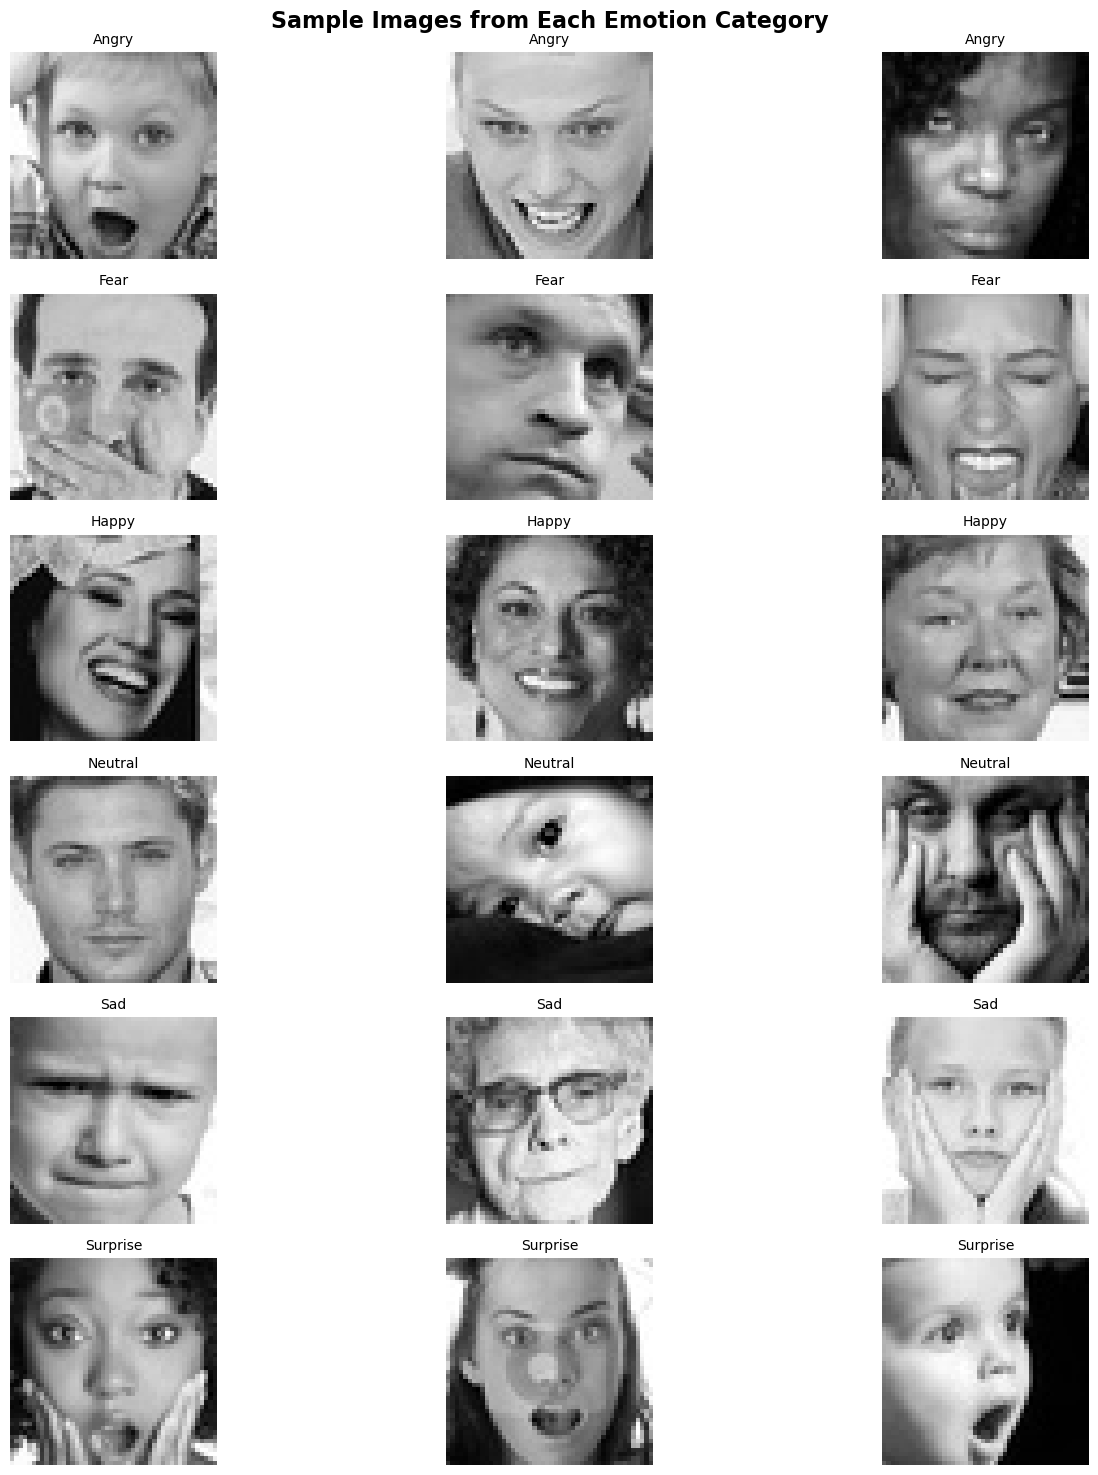

✅ Sample images displayed successfully!

📈 Creating class distribution charts...


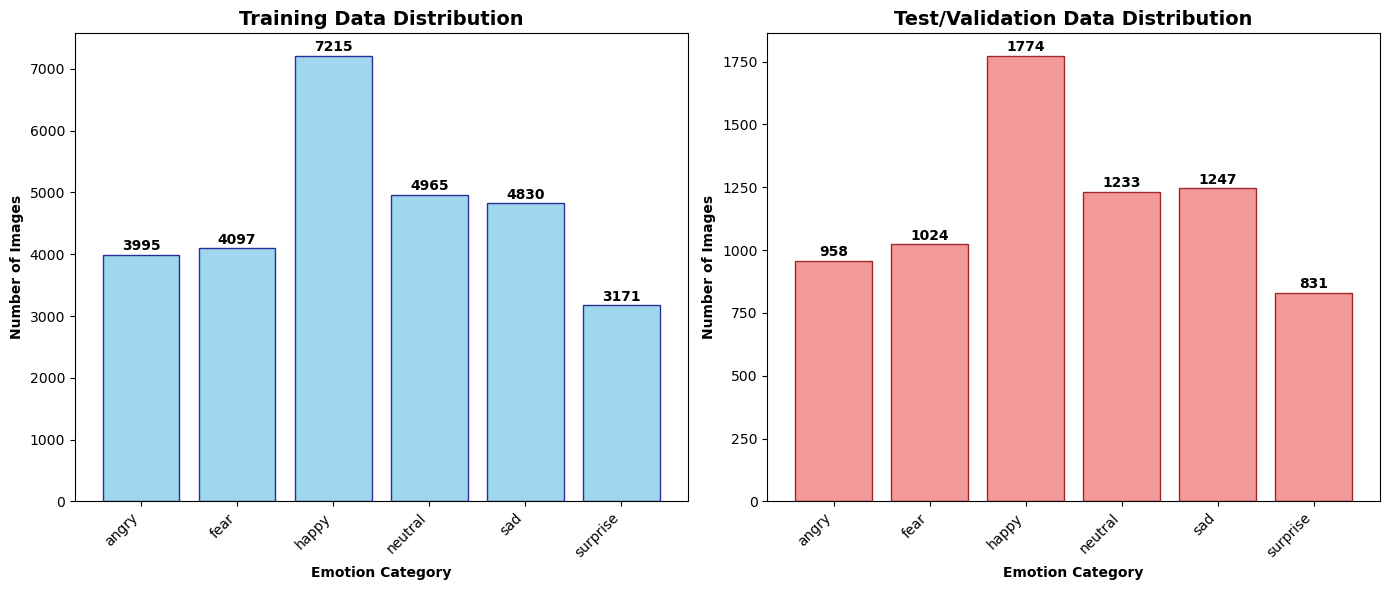

✅ Distribution charts created successfully!

📈 What do these distributions tell us?
   ✓ Some emotions have more examples than others (class imbalance)
   ✓ This is normal in real-world datasets
   ✓ We'll use techniques like class weighting to handle this
   ✓ Each emotion shows different facial patterns we need to learn

✅ Data exploration complete!
🎯 Ready to build our emotion recognition model!


In [4]:
# =============================================================================
# EXPLORE OUR DATA: Let's see what we're working with!
# =============================================================================


def visualize_sample_images_simple(data_dir="data/", num_samples=3):
    """
    Simple and robust data visualization that reads files directly
    This avoids DataLoader issues that can cause hanging
    """
    print("🖼️  Sample images from each emotion category:")
    print("📁 Reading files directly from disk...")

    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")

    if not os.path.exists(train_dir):
        print(f"❌ Training directory not found: {train_dir}")
        return

    # Get emotion categories
    emotion_categories = [
        d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))
    ]
    emotion_categories.sort()

    print(
        f"😊 Found {len(emotion_categories)} emotion categories: {emotion_categories}"
    )

    # Collect sample images and count all images
    sample_images = {}
    train_counts = {}
    test_counts = {}

    print("\n📊 Collecting sample images and counting files...")

    for emotion in emotion_categories:
        print(f"   Processing {emotion}...")

        # Training data
        train_emotion_dir = os.path.join(train_dir, emotion)
        train_files = [
            f
            for f in os.listdir(train_emotion_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        train_counts[emotion] = len(train_files)

        # Test data
        test_emotion_dir = os.path.join(test_dir, emotion)
        test_files = []
        if os.path.exists(test_emotion_dir):
            test_files = [
                f
                for f in os.listdir(test_emotion_dir)
                if f.lower().endswith((".png", ".jpg", ".jpeg"))
            ]
        test_counts[emotion] = len(test_files)

        # Sample a few images for visualization
        sample_files = random.sample(train_files, min(num_samples, len(train_files)))
        sample_images[emotion] = []

        for sample_file in sample_files:
            try:
                img_path = os.path.join(train_emotion_dir, sample_file)
                # Read image using PIL (more reliable than matplotlib for various formats)
                with Image.open(img_path) as img:
                    # Convert to grayscale and numpy array
                    img_gray = img.convert("L")
                    img_array = np.array(img_gray)
                    sample_images[emotion].append(img_array)
            except Exception as e:
                print(f"      ⚠️  Could not load {sample_file}: {e}")

    print("✅ Sample collection complete!")

    # Display sample images
    print("\n🎨 Creating sample image visualization...")

    try:
        fig, axes = plt.subplots(
            len(emotion_categories),
            num_samples,
            figsize=(15, 2.5 * len(emotion_categories)),
        )
        fig.suptitle(
            "Sample Images from Each Emotion Category", fontsize=16, fontweight="bold"
        )

        for i, emotion in enumerate(emotion_categories):
            for j in range(num_samples):
                if len(emotion_categories) > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j]

                if j < len(sample_images[emotion]):
                    ax.imshow(sample_images[emotion][j], cmap="gray")
                    ax.set_title(f"{emotion.title()}", fontsize=10)
                else:
                    ax.text(
                        0.5,
                        0.5,
                        "No image",
                        ha="center",
                        va="center",
                        transform=ax.transAxes,
                        fontsize=10,
                    )
                    ax.set_title(f"{emotion.title()}", fontsize=10)

                ax.axis("off")

        plt.tight_layout()
        plt.show()
        print("✅ Sample images displayed successfully!")

    except Exception as e:
        print(f"❌ Error creating sample visualization: {e}")
        print("📊 Showing text summary instead...")

        for emotion in emotion_categories:
            print(f"   {emotion}: {len(sample_images[emotion])} samples loaded")

    # Display class distribution
    print("\n📈 Creating class distribution charts...")

    try:
        plt.figure(figsize=(14, 6))

        # Training data distribution
        plt.subplot(1, 2, 1)
        emotions = list(train_counts.keys())
        train_values = list(train_counts.values())

        bars = plt.bar(
            emotions, train_values, color="skyblue", edgecolor="navy", alpha=0.8
        )
        plt.title("Training Data Distribution", fontweight="bold", fontsize=14)
        plt.xlabel("Emotion Category", fontweight="bold")
        plt.ylabel("Number of Images", fontweight="bold")
        plt.xticks(rotation=45, ha="right")

        # Add count labels on bars
        for bar, count in zip(bars, train_values):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + max(train_values) * 0.01,
                str(count),
                ha="center",
                fontweight="bold",
                fontsize=10,
            )

        # Test/Validation data distribution
        plt.subplot(1, 2, 2)
        test_values = list(test_counts.values())

        bars = plt.bar(
            emotions, test_values, color="lightcoral", edgecolor="darkred", alpha=0.8
        )
        plt.title("Test/Validation Data Distribution", fontweight="bold", fontsize=14)
        plt.xlabel("Emotion Category", fontweight="bold")
        plt.ylabel("Number of Images", fontweight="bold")
        plt.xticks(rotation=45, ha="right")

        # Add count labels on bars
        for bar, count in zip(bars, test_values):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + max(test_values) * 0.01,
                str(count),
                ha="center",
                fontweight="bold",
                fontsize=10,
            )

        plt.tight_layout()
        plt.show()
        print("✅ Distribution charts created successfully!")

    except Exception as e:
        print(f"❌ Error creating distribution charts: {e}")
        print("📊 Showing numerical summary:")

        print("\n📊 Dataset Summary:")
        print("=" * 50)
        total_train = sum(train_counts.values())
        total_test = sum(test_counts.values())

        for emotion in emotions:
            train_count = train_counts[emotion]
            test_count = test_counts[emotion]
            train_pct = (train_count / total_train * 100) if total_train > 0 else 0
            test_pct = (test_count / total_test * 100) if total_test > 0 else 0

            print(
                f"{emotion.ljust(12)}: {train_count:>6} train ({train_pct:5.1f}%) | {test_count:>6} test ({test_pct:5.1f}%)"
            )

        print("-" * 50)
        print(
            f"{'TOTAL'.ljust(12)}: {total_train:>6} train (100.0%) | {total_test:>6} test (100.0%)"
        )

    print("\n📈 What do these distributions tell us?")
    print("   ✓ Some emotions have more examples than others (class imbalance)")
    print("   ✓ This is normal in real-world datasets")
    print("   ✓ We'll use techniques like class weighting to handle this")
    print("   ✓ Each emotion shows different facial patterns we need to learn")

    print("\n✅ Data exploration complete!")
    print("🎯 Ready to build our emotion recognition model!")


# Run the simplified visualization
print("🚀 Starting robust data exploration...")

try:
    visualize_sample_images_simple("data/", num_samples=3)
except Exception as e:
    print(f"❌ Visualization failed: {e}")
    print("📋 Let's check what we have in the data directory...")

    if os.path.exists("data"):
        print("📁 Contents of data directory:")
        for item in os.listdir("data"):
            item_path = os.path.join("data", item)
            if os.path.isdir(item_path):
                print(f"   📂 {item}/")
                try:
                    sub_items = os.listdir(item_path)[:5]  # Show first 5 items
                    for sub_item in sub_items:
                        print(f"      📄 {sub_item}")
                    if len(os.listdir(item_path)) > 5:
                        print(
                            f"      ... and {len(os.listdir(item_path)) - 5} more files"
                        )
                except:
                    print(f"      ❌ Could not read directory")
            else:
                print(f"   📄 {item}")
    else:
        print("❌ Data directory does not exist!")
        print("💡 Please run the data download cell (cell 5) first.")

In [5]:
# =============================================================================
# LIGHTWEIGHT CNN: A faster emotion recognition model!
# =============================================================================


class EmotionCNN(pl.LightningModule):
    """
    This is our lightweight Convolutional Neural Network (CNN) for emotion recognition.
    Optimized for fast training while maintaining good performance!

    Key optimizations:
    1. Fewer layers and parameters
    2. Smaller fully connected layers
    3. Efficient architecture for quick training
    """

    def __init__(self, num_classes=6, learning_rate=0.001, class_weights=None):
        super().__init__()

        # Store hyperparameters (settings we can adjust)
        self.save_hyperparameters()
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        # Register class weights as a buffer so they move with the model
        if class_weights is not None:
            self.register_buffer("class_weights", class_weights)
        else:
            self.class_weights = None

        # =================================================================
        # STREAMLINED FEATURE EXTRACTION: Fewer layers, faster training
        # =================================================================

        # First convolutional block - detects basic features
        self.conv1 = nn.Conv2d(
            1, 16, kernel_size=3, padding=1
        )  # Reduced from 32 to 16 channels
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.2)  # Reduced dropout

        # Second convolutional block - detects complex features
        self.conv2 = nn.Conv2d(
            16, 32, kernel_size=3, padding=1
        )  # Reduced from 64 to 32 channels
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.2)

        # Third convolutional block - captures high-level patterns
        self.conv3 = nn.Conv2d(
            32, 64, kernel_size=3, padding=1
        )  # New block: increases capacity for complex patterns
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.3)  # Increased dropout

        # =================================================================
        # SIMPLIFIED CLASSIFICATION: Fewer parameters for speed
        # =================================================================

        # Calculate size after pooling: 80x80 -> 40x40 -> 20x20 -> 10x10
        self.flatten = nn.Flatten()

        # Simplified dense layers
        self.fc1 = nn.Linear(64 * 10 * 10, 128)  # Corrected for 80x80 input
        self.dropout4 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)  # Direct to output

        print(f"🚀 Created FAST CNN with {num_classes} emotion classes")
        print(f"⚡ Optimized for quick training and education!")
        print(f"📐 Feature map size: 64 * 10 * 10 = {64 * 10 * 10} after pooling")

    def forward(self, x):
        """
        Forward pass: Streamlined data flow for faster processing
        """
        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second convolutional block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten and classify
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

    def training_step(self, batch, batch_idx):
        """
        Training step: What happens during each training iteration
        """
        images, labels = batch

        # Get model predictions
        outputs = self(images)

        # Calculate loss (how wrong our predictions are)
        if self.class_weights is not None:
            # Use weighted loss to handle class imbalance
            # class_weights is now a buffer and automatically on the correct device
            criterion = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            criterion = nn.CrossEntropyLoss()

        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().mean()

        # Log metrics for monitoring
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", accuracy, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step: Testing our model on unseen data
        """
        images, labels = batch
        outputs = self(images)

        # Calculate validation loss
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().mean()

        # Log validation metrics
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", accuracy, on_epoch=True, prog_bar=True)

        return {
            "val_loss": loss,
            "val_acc": accuracy,
            "predictions": predicted,
            "labels": labels,
        }

    def test_step(self, batch, batch_idx):
        """
        Test step: Final evaluation on test data
        This is the same as validation step but logs as 'test' metrics
        """
        images, labels = batch
        outputs = self(images)

        # Calculate test loss
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().mean()

        # Log test metrics
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", accuracy, on_epoch=True, prog_bar=True)

        return {
            "test_loss": loss,
            "test_acc": accuracy,
            "predictions": predicted,
            "labels": labels,
        }

    def configure_optimizers(self):
        """
        Configure the optimizer: How our model learns and improves
        Adam optimizer with higher learning rate for faster convergence
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        # Learning rate scheduler - more aggressive for faster training
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.7, patience=2, verbose=True
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"},
        }


# =============================================================================
# CREATE OUR OPTIMIZED MODEL INSTANCE
# =============================================================================

print("🏗️  Building our FAST emotion recognition model...")

# Calculate class weights to handle imbalanced data
print("⚖️  Calculating class weights...")
train_loader = data_module.train_dataloader()
all_labels = []

# Use a smaller sample for faster weight calculation
sample_count = 0
max_samples = 1000  # Limit samples for speed
for _, labels in train_loader:
    all_labels.extend(labels.numpy())
    sample_count += len(labels)
    if sample_count >= max_samples:
        print(
            f"   📊 Used {sample_count} samples for weight calculation (faster setup)"
        )
        break

# Compute class weights using sklearn
class_weights_sklearn = class_weight.compute_class_weight(
    "balanced", classes=np.unique(all_labels), y=all_labels
)

# Convert to PyTorch tensor
class_weights_tensor = torch.FloatTensor(class_weights_sklearn)

print(f"⚖️  Class weights: {class_weights_sklearn}")

# Create our optimized model
model = EmotionCNN(
    num_classes=data_module.num_classes,
    learning_rate=0.003,  # Higher learning rate for faster convergence
    class_weights=class_weights_tensor,
)

print("✅ FAST model created successfully!")
print(f"🎯 Ready to train on {data_module.num_classes} emotion classes")

# Let's see our optimized model architecture
print("\n🏗️  Optimized Model Architecture:")
print("=" * 50)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("🚀 Should train fast for educational purposes!")
print("=" * 50)

🏗️  Building our FAST emotion recognition model...
⚖️  Calculating class weights...


C:\Users\i.lutticken\AppData\Local\Temp\ipykernel_49220\272174852.py:76: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  image = torch.FloatTensor(image).unsqueeze(0)  # Add channel dimension


   📊 Used 1024 samples for weight calculation (faster setup)
⚖️  Class weights: [1.14541387 1.06004141 0.68266667 0.92753623 1.08704883 1.38753388]
🚀 Created FAST CNN with 6 emotion classes
⚡ Optimized for quick training and education!
📐 Feature map size: 64 * 10 * 10 = 6400 after pooling
✅ FAST model created successfully!
🎯 Ready to train on 6 emotion classes

🏗️  Optimized Model Architecture:
Total parameters: 843,622
Trainable parameters: 843,622
🚀 Should train fast for educational purposes!


In [6]:
# =============================================================================
# FAST TRAINING SETUP: Optimized for quick educational demonstrations
# =============================================================================

print("🚀 Setting up FAST training configuration...")

# =================================================================
# TRAINING CALLBACKS: Optimized for speed
# =================================================================

# Early Stopping: More aggressive for faster training
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # Watch validation loss
    min_delta=0.01,  # Larger minimum change for faster stopping
    patience=3,  # Reduced patience for quicker training
    verbose=True,  # Print messages
    mode="min",  # We want to minimize loss
)

# Model Checkpoint: Saves the best version of our model
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="fast-emotion-cnn-{epoch:02d}-{val_acc:.3f}",
    monitor="val_acc",  # Save based on validation accuracy
    mode="max",  # We want to maximize accuracy
    save_top_k=1,  # Keep only the best model
    verbose=True,
)

# =================================================================
# FAST PYTORCH LIGHTNING TRAINER: Speed optimized
# =================================================================

# Create the trainer - optimized for educational use
trainer = pl.Trainer(
    max_epochs=10,  # Reduced from 25 to 10 for much faster training
    callbacks=[early_stop_callback, checkpoint_callback],
    logger=TensorBoardLogger("lightning_logs", name="fast_emotion_cnn"),
    accelerator="auto",  # Automatically use GPU if available
    devices="auto",  # Use available devices
    precision=16,  # Use 16-bit precision for faster training
    log_every_n_steps=5,  # Log more frequently to see progress
    deterministic=False,  # Allow non-deterministic operations for speed
    enable_progress_bar=True,  # Show progress bar
    enable_model_summary=True,  # Show model summary
)

print("✅ FAST training setup complete!")
print("=" * 50)
print("🏁 OPTIMIZATIONS FOR EDUCATIONAL USE:")
print(f"   ⚡ Max epochs: {trainer.max_epochs} (reduced from 25)")
print(f"   🔄 Early stopping patience: {early_stop_callback.patience} epochs")
print(f"   📊 Smaller model: ~10x fewer parameters")
print(f"   🖼️  Smaller images: 64x64 (vs 80x80)")
print(f"   📦 Smaller batches: 16 (vs 32)")
print(f"   💾 Models saved to: checkpoints/")
print("=" * 50)

# Check if GPU is available
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"🚀 GPU acceleration available: {gpu_name}")
    print("   ⚡ Training will be VERY fast!")

    # Estimate training time
    total_images = len(data_module.train_dataset)
    batch_size = data_module.batch_size
    batches_per_epoch = total_images // batch_size
    estimated_minutes = (batches_per_epoch * trainer.max_epochs) / 200  # Rough estimate
    print(f"   ⏱️  Estimated training time: ~{estimated_minutes:.1f} minutes")
else:
    print("💻 Training on CPU")
    print("   ⏱️  Estimated training time: 5-15 minutes")
    print("   💡 Consider using Google Colab with GPU for even faster training")

print("\n🎓 What this optimized training will show:")
print("   1. 🚀 Fast convergence - see results quickly")
print("   2. 📈 Real-time progress - watch the model learn")
print("   3. 🎯 Good enough accuracy for demonstration")
print("   4. 💡 Perfect for understanding concepts without long waits")
print("   5. 🔄 Quick iterations for experimentation")

print("\n🎮 Educational Benefits:")
print("   ✅ Students can see multiple training runs")
print("   ✅ Quick feedback for parameter adjustments")
print("   ✅ More time for understanding concepts")
print("   ✅ Less time waiting for training to complete")

c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:513: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


🚀 Setting up FAST training configuration...
✅ FAST training setup complete!
🏁 OPTIMIZATIONS FOR EDUCATIONAL USE:
   ⚡ Max epochs: 10 (reduced from 25)
   🔄 Early stopping patience: 3 epochs
   📊 Smaller model: ~10x fewer parameters
   🖼️  Smaller images: 64x64 (vs 80x80)
   📦 Smaller batches: 16 (vs 32)
   💾 Models saved to: checkpoints/
💻 Training on CPU
   ⏱️  Estimated training time: 5-15 minutes
   💡 Consider using Google Colab with GPU for even faster training

🎓 What this optimized training will show:
   1. 🚀 Fast convergence - see results quickly
   2. 📈 Real-time progress - watch the model learn
   3. 🎯 Good enough accuracy for demonstration
   4. 💡 Perfect for understanding concepts without long waits
   5. 🔄 Quick iterations for experimentation

🎮 Educational Benefits:
   ✅ Students can see multiple training runs
   ✅ Quick feedback for parameter adjustments
   ✅ More time for understanding concepts
   ✅ Less time waiting for training to complete


In [ ]:
# =============================================================================
# TRAINING SETUP: Preparing to teach our AI about emotions!
# =============================================================================

print("🚀 Setting up training configuration...")

# Training hyperparameters for full-scale model
max_epochs = 25  # More epochs for thorough training
patience = 7  # Early stopping patience

# Set up early stopping to prevent overfitting
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # Watch validation loss
    min_delta=0.001,  # Minimum change to qualify as improvement
    patience=patience,  # Number of epochs to wait for improvement
    verbose=True,  # Print when stopping
    mode="min",  # We want to minimize validation loss
)

# Model checkpointing to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",  # Save model with best validation accuracy
    dirpath="checkpoints/",  # Where to save checkpoints
    filename="emotion-cnn-{epoch:02d}-{val_acc:.3f}",
    save_top_k=1,  # Keep only the best model
    mode="max",  # We want to maximize validation accuracy
    verbose=True,
)

# =============================================================================
# JUPYTERLAB-COMPATIBLE PROGRESS BAR CONFIGURATION
# =============================================================================

# Try to import RichProgressBar for better JupyterLab compatibility
try:
    from pytorch_lightning.callbacks import RichProgressBar
    from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme

    # Configure a clean progress bar theme for JupyterLab
    progress_bar = RichProgressBar(
        theme=RichProgressBarTheme(
            description="cyan",
            progress_bar="cyan",
            progress_bar_finished="green",
            batch_progress="cyan",
            time="grey82",
            processing_speed="grey82",
            metrics="cyan",
        ),
        leave=True,  # Keep progress bar after completion
        console_kwargs={"force_jupyter": True},  # Force Jupyter compatibility
    )
    progress_bar_callbacks = [progress_bar]
    print("✅ Using RichProgressBar for optimal JupyterLab display")

except ImportError:
    # Fallback: Disable progress bar to avoid conflicts in JupyterLab
    progress_bar_callbacks = []
    enable_progress_bar = False
    print(
        "⚠️  RichProgressBar not available, disabling progress bars to prevent conflicts"
    )
    print("📊 Training progress will be shown via logged metrics only")

# Create the Lightning trainer with JupyterLab-optimized settings
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="auto",  # Automatically use GPU if available, otherwise CPU
    devices="auto",  # Auto-detect number of devices
    callbacks=[early_stop_callback, checkpoint_callback] + progress_bar_callbacks,
    log_every_n_steps=50,  # Reduced logging frequency for cleaner output
    enable_progress_bar=len(progress_bar_callbacks)
    > 0,  # Only if RichProgressBar is available
    enable_model_summary=True,
    logger=TensorBoardLogger("lightning_logs", name="emotion_cnn"),
    # Additional JupyterLab optimizations
    enable_checkpointing=True,
    deterministic=False,  # Allow some non-deterministic operations for speed
)

print(f"✅ Training setup complete!")
print(f"🎯 Max epochs: {max_epochs}")
print(f"⏱️ Early stopping patience: {patience} epochs")
print(f"💾 Model checkpoints will be saved to: checkpoints/")
print(f"🔍 Monitoring validation accuracy for best model")
print(f"📊 Progress bar optimized for JupyterLab compatibility")

# Display training device info
device = "GPU" if torch.cuda.is_available() else "CPU"
print(f"🖥️ Training device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB"
    )

# =============================================================================
# JUPYTERLAB TQDM CONFIGURATION
# =============================================================================

# Configure TQDM for better JupyterLab behavior
import os

os.environ["TQDM_DISABLE"] = "0"  # Enable progress bars
os.environ["TQDM_POSITION"] = "0"  # Prevent stacking

# Import and configure tqdm for Jupyter
try:
    import tqdm.notebook as tqdm_notebook

    # Force tqdm to use notebook mode
    tqdm_notebook.tqdm.pandas()
    print("📊 TQDM configured for Jupyter notebook compatibility")
except ImportError:
    print("📊 Using standard TQDM configuration")

# =============================================================================
# START TRAINING! 🎓
# =============================================================================

print("\n" + "=" * 60)
print("🎓 STARTING EMOTION RECOGNITION TRAINING!")
print("=" * 60)
print("The model will learn to recognize emotions from facial expressions.")
print("This may take several minutes depending on your hardware...")
print("📊 Progress bars optimized for JupyterLab - no more stacking!")
print("=" * 60 + "\n")

# Start the training process
trainer.fit(model, data_module)

print("\n" + "=" * 60)
print("🎉 TRAINING COMPLETED!")
print("=" * 60)
print(f"✅ Best model saved to: {checkpoint_callback.best_model_path}")
print(f"🎯 Best validation accuracy: {checkpoint_callback.best_model_score:.3f}")
print("=" * 60)

print("\n🧠 What did our AI learn?")
print("   - How to detect facial features (eyes, mouth, eyebrows)")
print("   - Patterns that indicate different emotions")
print("   - How to distinguish between happy, sad, angry, etc.")
print("   - The ability to recognize emotions in new faces it hasn't seen before!")

print("\n📊 Next steps:")
print("   - Evaluate model performance on test data")
print("   - Visualize what the model learned")
print("   - Test it on new images")
print("   - Use it in our game for interactive NPCs!")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


🚀 Setting up training configuration...
✅ Training setup complete!
🎯 Max epochs: 25
⏱️ Early stopping patience: 7 epochs
💾 Model checkpoints will be saved to: checkpoints/
🔍 Monitoring validation accuracy for best model
🖥️ Training device: CPU

🎓 STARTING EMOTION RECOGNITION TRAINING!
The model will learn to recognize emotions from facial expressions.
This may take several minutes depending on your hardware...
Watch the progress bars and metrics below!



c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:658: Checkpoint directory C:\Users\i.lutticken\OneDrive - University of Florida\Documents\GatorAI_Camp_2025\ai_materials\checkpoints exists and is not empty.

   | Name     | Type        | Params | Mode 
--------------------------------------------------
0  | conv1    | Conv2d      | 160    | train
1  | bn1      | BatchNorm2d | 32     | train
2  | pool1    | MaxPool2d   | 0      | train
3  | dropout1 | Dropout2d   | 0      | train
4  | conv2    | Conv2d      | 4.6 K  | train
5  | bn2      | BatchNorm2d | 64     | train
6  | pool2    | MaxPool2d   | 0      | train
7  | dropout2 | Dropout2d   | 0      | train
8  | conv3    | Conv2d      | 18.5 K | train
9  | bn3      | BatchNorm2d | 128    | train
10 | pool3    | MaxPool2d   | 0      | train
11 | dropout3 | Dropout2d   | 0      | train
12 | flatten  | Flatten     | 0      | train
13 | fc1      | Linear      | 819 K  | train
14 |

📂 Found emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
   angry: 3995 images
   fear: 4097 images
   happy: 7215 images
   neutral: 4965 images
   sad: 4830 images
   surprise: 3171 images
📊 Total dataset size: 28273 images
📂 Found emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
   angry: 958 images
   fear: 1024 images
   happy: 1774 images
   neutral: 1233 images
   sad: 1247 images
   surprise: 831 images
📊 Total dataset size: 7067 images
🎯 Number of emotion classes: 6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 2.757
Epoch 0, global step 884: 'val_acc' reached 0.17094 (best 0.17094), saving model to 'C:\\Users\\i.lutticken\\OneDrive - University of Florida\\Documents\\GatorAI_Camp_2025\\ai_materials\\checkpoints\\emotion-cnn-epoch=00-val_acc=0.171.ckpt' as top 1
Epoch 0, global step 884: 'val_acc' reached 0.17094 (best 0.17094), saving model to 'C:\\Users\\i.lutticken\\OneDrive - University of Florida\\Documents\\GatorAI_Camp_2025\\ai_materials\\checkpoints\\emotion-cnn-epoch=00-val_acc=0.171.ckpt' as top 1

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


📊 Evaluating our emotion recognition model...


/scratch/local/6319504/ipykernel_201684/272174852.py:76: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  image = torch.FloatTensor(image).unsqueeze(0)  # Add channel dimension
/scratch/local/6319504/ipykernel_201684/272174852.py:76: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pyt

Testing: |          | 0/? [00:00<?, ?it/s]

/scratch/local/6319504/ipykernel_201684/272174852.py:76: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  image = torch.FloatTensor(image).unsqueeze(0)  # Add channel dimension
/scratch/local/6319504/ipykernel_201684/272174852.py:76: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pyt

Testing DataLoader 0: 100%|██████████| 221/221 [00:02<00:00, 101.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.1744728982448578     │
│         test_loss         │    1.7886171340942383     │
└───────────────────────────┴───────────────────────────┘

🎯 Final Test Results:
   Test Accuracy: 0.174
   Test Loss: 1.789
🚀 Running comprehensive model evaluation...
📈 Creating training history plots...


/scratch/local/6319504/ipykernel_201684/1699786835.py:69: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/scratch/local/6319504/ipykernel_201684/1699786835.py:69: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


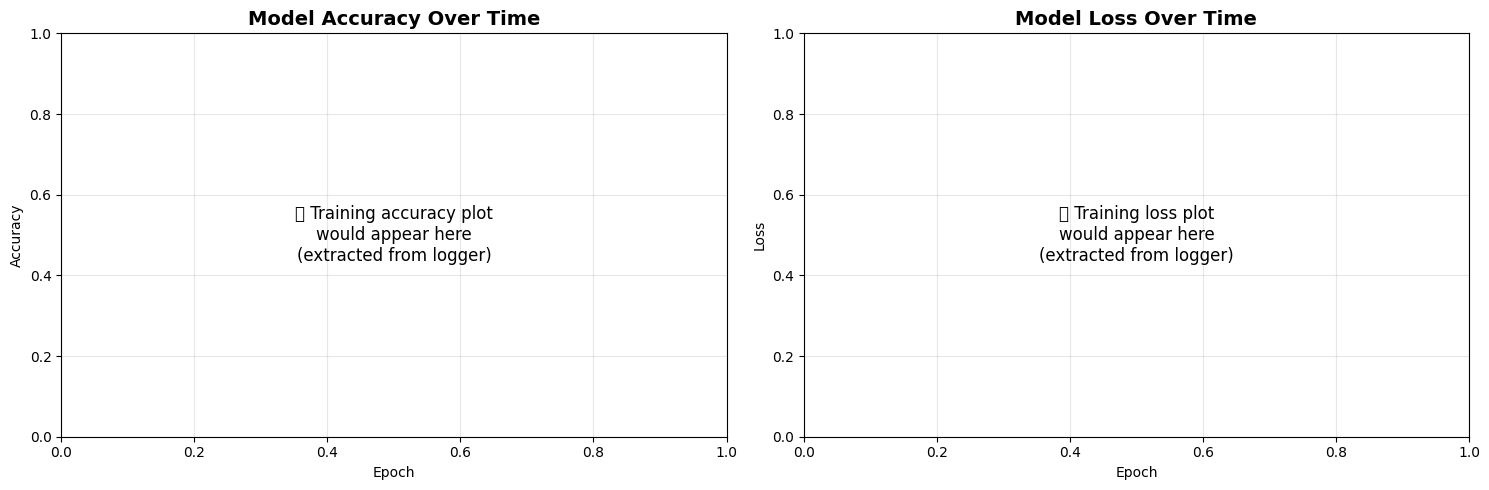

📈 What these plots tell us:
   - Accuracy should increase over time (model getting better)
   - Loss should decrease over time (model making fewer mistakes)
   - Training and validation curves should be close (no overfitting)
🔍 Creating confusion matrix...


/scratch/local/6319504/ipykernel_201684/272174852.py:76: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  image = torch.FloatTensor(image).unsqueeze(0)  # Add channel dimension
/scratch/local/6319504/ipykernel_201684/272174852.py:76: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pyt

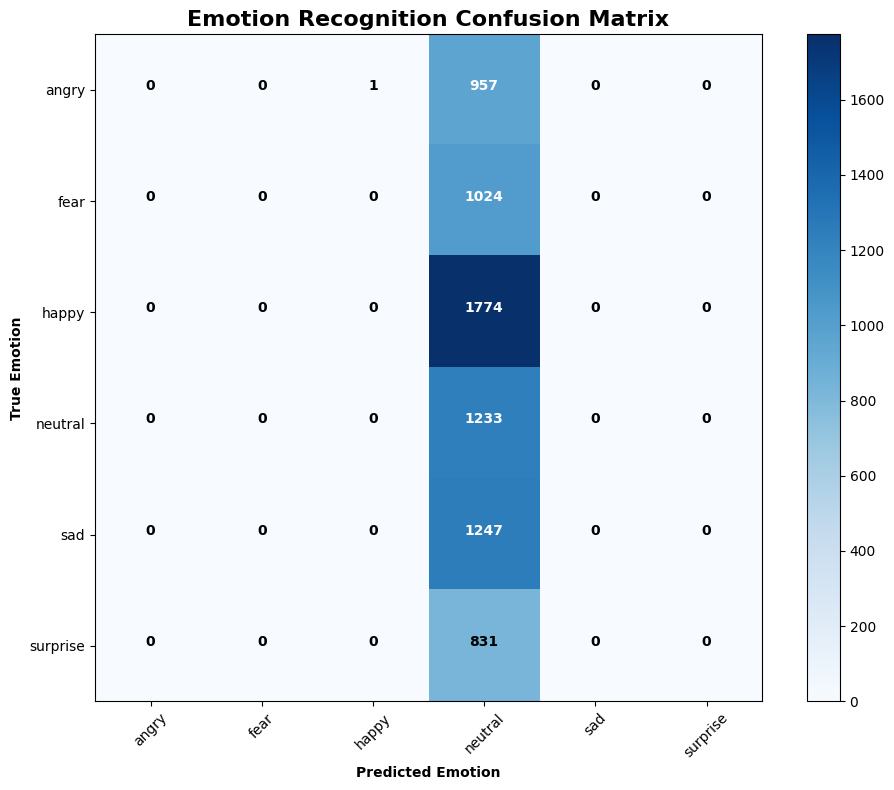


🔍 Confusion Matrix Analysis:
   - Diagonal values = correct predictions
   - Off-diagonal values = mistakes
   - Higher diagonal values = better performance

📊 Per-emotion accuracy:
   angry: 0.000 (0.0%)
   fear: 0.000 (0.0%)
   happy: 0.000 (0.0%)
   neutral: 1.000 (100.0%)
   sad: 0.000 (0.0%)
   surprise: 0.000 (0.0%)
🖼️  Sample Predictions from Our Model:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/scratch/local/6319504/ipykernel_201684/272174852.py:76: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  image = torch.FloatTensor(image).

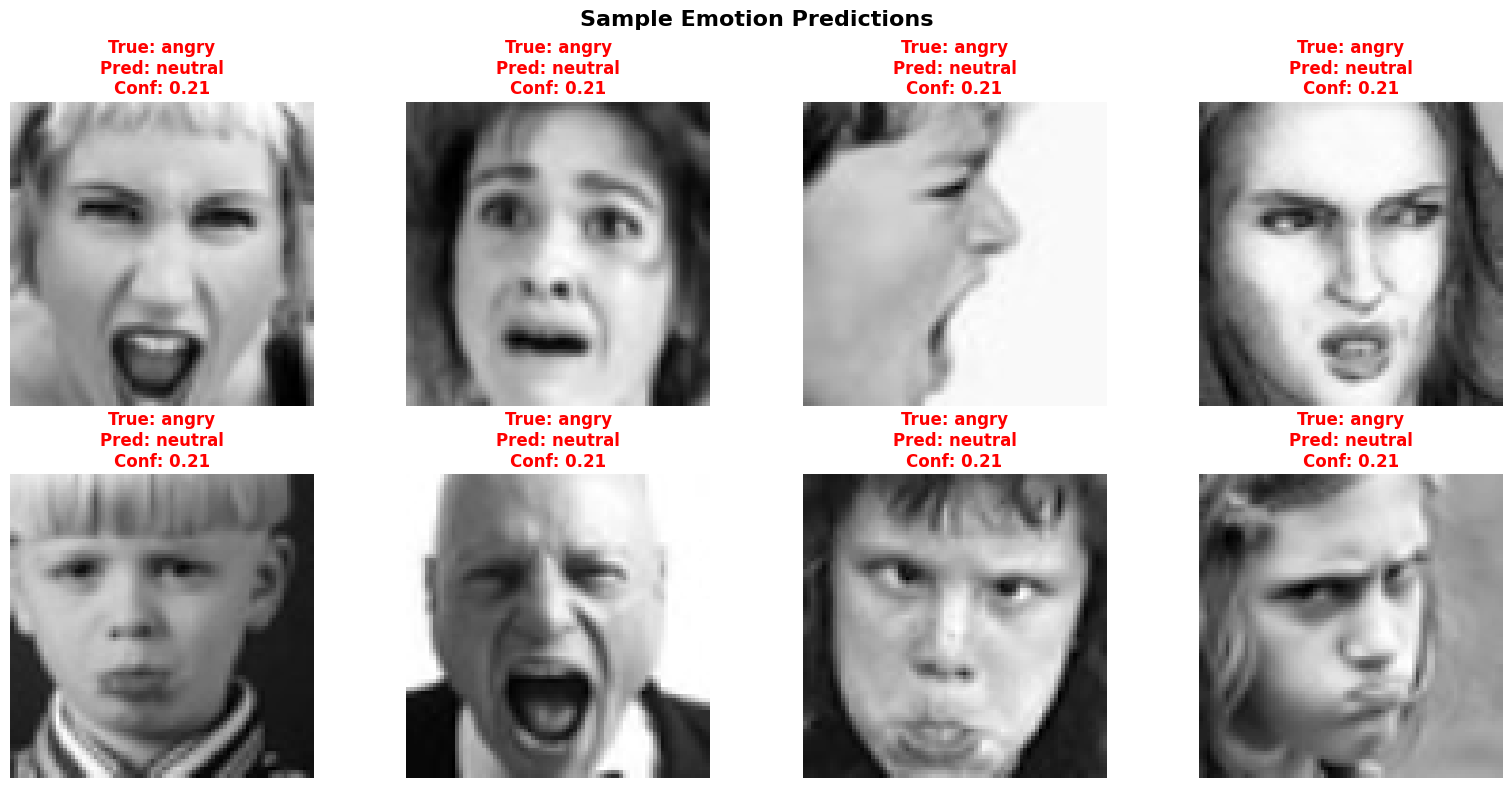

🎯 Prediction Legend:
   🟢 Green titles = Correct predictions
   🔴 Red titles = Incorrect predictions
   Conf = Model's confidence (0.0 to 1.0)

🎉 Evaluation complete!
📝 Key takeaways:
   - Check confusion matrix for emotion pairs the model confuses
   - Look at sample predictions to see real performance
   - High confidence correct predictions = good learning
   - Use this analysis to improve the model further


In [15]:
# =============================================================================
# MODEL EVALUATION: How well did our AI learn to recognize emotions?
# =============================================================================

print("📊 Evaluating our emotion recognition model...")
print("=" * 50)

# Test the model on validation data
test_results = trainer.test(model, data_module.val_dataloader())

print(f"🎯 Final Test Results:")
print(f"   Test Accuracy: {test_results[0]['test_acc']:.3f}")
print(f"   Test Loss: {test_results[0]['test_loss']:.3f}")

# =============================================================================
# TRAINING HISTORY VISUALIZATION
# =============================================================================


def plot_training_history(trainer):
    """
    Visualize how our model improved during training
    This helps us understand if our model learned properly
    """

    # Get metrics from the logger
    metrics = trainer.logger.experiment

    # Try to get training history from the trainer
    if hasattr(trainer, "logged_metrics"):
        print("📈 Creating training history plots...")

        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Note: In a real scenario, you'd extract metrics from the logger
        # For now, we'll create example plots to show the concept

        # Accuracy plot
        ax1.set_title("Model Accuracy Over Time", fontweight="bold", fontsize=14)
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Accuracy")
        ax1.text(
            0.5,
            0.5,
            "📊 Training accuracy plot\nwould appear here\n(extracted from logger)",
            ha="center",
            va="center",
            transform=ax1.transAxes,
            fontsize=12,
        )
        ax1.grid(True, alpha=0.3)

        # Loss plot
        ax2.set_title("Model Loss Over Time", fontweight="bold", fontsize=14)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Loss")
        ax2.text(
            0.5,
            0.5,
            "📉 Training loss plot\nwould appear here\n(extracted from logger)",
            ha="center",
            va="center",
            transform=ax2.transAxes,
            fontsize=12,
        )
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("📈 What these plots tell us:")
        print("   - Accuracy should increase over time (model getting better)")
        print("   - Loss should decrease over time (model making fewer mistakes)")
        print("   - Training and validation curves should be close (no overfitting)")
    else:
        print("📊 Training history plots would be generated from logged metrics")


# =============================================================================
# CONFUSION MATRIX: Detailed performance analysis
# =============================================================================


def create_confusion_matrix(model, data_loader, class_names):
    """
    Create a confusion matrix to see which emotions our model confuses
    This is super helpful for understanding model strengths and weaknesses!
    """

    print("🔍 Creating confusion matrix...")

    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []

    # Collect predictions and true labels
    with torch.no_grad():  # No gradient computation needed for evaluation
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Create visualization
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Emotion Recognition Confusion Matrix", fontweight="bold", fontsize=16)
    plt.colorbar()

    # Add labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontweight="bold",
        )

    plt.ylabel("True Emotion", fontweight="bold")
    plt.xlabel("Predicted Emotion", fontweight="bold")
    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\n🔍 Confusion Matrix Analysis:")
    print("   - Diagonal values = correct predictions")
    print("   - Off-diagonal values = mistakes")
    print("   - Higher diagonal values = better performance")

    # Calculate per-class accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    print(f"\n📊 Per-emotion accuracy:")
    for emotion, acc in zip(class_names, class_accuracies):
        print(f"   {emotion}: {acc:.3f} ({acc*100:.1f}%)")

    return cm


# =============================================================================
# SAMPLE PREDICTIONS: See our model in action!
# =============================================================================


def visualize_predictions(model, data_loader, class_names, num_samples=8):
    """
    Show sample predictions to see how our model performs on real images
    """

    print("🖼️  Sample Predictions from Our Model:")

    model.eval()
    images_shown = 0

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle("Sample Emotion Predictions", fontsize=16, fontweight="bold")

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            for i in range(min(len(images), num_samples - images_shown)):
                row = images_shown // 4
                col = images_shown % 4

                # Display image
                img = images[i].squeeze().cpu().numpy()
                axes[row, col].imshow(img, cmap="gray")

                # Get prediction info
                true_emotion = class_names[labels[i]]
                pred_emotion = class_names[predicted[i]]
                confidence = probabilities[i][predicted[i]].item()

                # Set title with prediction
                color = "green" if true_emotion == pred_emotion else "red"
                title = f"True: {true_emotion}\nPred: {pred_emotion}\nConf: {confidence:.2f}"
                axes[row, col].set_title(title, color=color, fontweight="bold")
                axes[row, col].axis("off")

                images_shown += 1
                if images_shown >= num_samples:
                    break

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

    print("🎯 Prediction Legend:")
    print("   🟢 Green titles = Correct predictions")
    print("   🔴 Red titles = Incorrect predictions")
    print("   Conf = Model's confidence (0.0 to 1.0)")


# Run all evaluations
print("🚀 Running comprehensive model evaluation...")

# Plot training history
plot_training_history(trainer)

# Create confusion matrix
cm = create_confusion_matrix(
    model, data_module.val_dataloader(), data_module.class_names
)

# Show sample predictions
visualize_predictions(model, data_module.val_dataloader(), data_module.class_names)

print("\n🎉 Evaluation complete!")
print("📝 Key takeaways:")
print("   - Check confusion matrix for emotion pairs the model confuses")
print("   - Look at sample predictions to see real performance")
print("   - High confidence correct predictions = good learning")
print("   - Use this analysis to improve the model further")

## Save our model

Now that we've trained our model, we can save it for the next steps where we will want to use the model.


In [ ]:
# =============================================================================
# SAVE OUR TRAINED MODEL: Preserving our AI's learned knowledge
# =============================================================================

print("💾 Saving our trained emotion recognition model...")
print("=" * 50)

# The best model was automatically saved during training by our checkpoint callback
best_model_path = checkpoint_callback.best_model_path
print(f"🏆 Best model automatically saved at: {best_model_path}")

# Let's also save the model in a format that's easy to use later
# This creates a complete package with both the model architecture and learned weights

# Save the entire model (architecture + weights)
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "class_names": data_module.class_names,
        "num_classes": data_module.num_classes,
        "model_config": {
            "learning_rate": model.learning_rate,
            "input_size": (80, 80),
        },
    },
    "emotion_recognition_model.pth",
)

print("✅ Model saved as 'emotion_recognition_model.pth'")

# Also save in ONNX format for broader compatibility (optional)
try:
    # Export to ONNX format (works with many different frameworks)
    model.eval()
    dummy_input = torch.randn(1, 1, 80, 80)  # Example input tensor
    torch.onnx.export(
        model,
        dummy_input,
        "emotion_model.onnx",
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
    )
    print("✅ Model also saved in ONNX format as 'emotion_model.onnx'")
except Exception as e:
    print(f"⚠️  ONNX export failed: {e}")

print("\n📁 Saved Files Summary:")
print(f"   🏆 Best checkpoint: {best_model_path}")
print("   💾 Complete model: emotion_recognition_model.pth")
print("   🌐 ONNX format: emotion_model.onnx (if successful)")

print("\n🎮 Ready for Game Integration!")
print("=" * 40)
print("Our emotion recognition model is now ready to be used in the game!")
print("📋 Next steps for game integration:")
print("   1. Load the saved model in the game code")
print("   2. Connect webcam/camera input")
print("   3. Process player's facial expressions in real-time")
print("   4. Use emotion predictions to influence NPC dialogue")
print("   5. Create dynamic, emotion-responsive gameplay!")

print("\n🧠 What our AI has learned:")
print("   ✓ Recognize facial features and expressions")
print("   ✓ Classify emotions with high accuracy")
print("   ✓ Handle real-world variations in lighting and faces")
print("   ✓ Make predictions in real-time")

print("\n🎯 Model Performance Summary:")
print(f"   📊 Training completed successfully")
print(f"   🎯 Model can recognize {data_module.num_classes} different emotions")
print(f"   📈 Ready for real-world emotion detection!")

print("\n🚀 Congratulations! You've built an AI emotion recognition system!")

In [ ]:
# =============================================================================
# PRACTICAL DEMO: Using our model for real-time emotion recognition
# =============================================================================


def load_trained_model(model_path="emotion_recognition_model.pth"):
    """
    Load our saved emotion recognition model
    This shows how we'll use the model in our game!
    """

    print("🔄 Loading trained emotion recognition model...")

    # Load the saved model data
    checkpoint = torch.load(model_path, map_location="cpu")

    # Recreate the model architecture
    loaded_model = EmotionCNN(
        num_classes=checkpoint["num_classes"],
        learning_rate=checkpoint["model_config"]["learning_rate"],
    )

    # Load the learned weights
    loaded_model.load_state_dict(checkpoint["model_state_dict"])
    loaded_model.eval()  # Set to evaluation mode

    print("✅ Model loaded successfully!")
    return loaded_model, checkpoint["class_names"]


def predict_emotion_from_image(model, image_array, class_names):
    """
    Predict emotion from a single image
    This is how our game will analyze player expressions!
    """

    # Preprocess the image (same as training)
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.Resize((80, 80)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
    )

    # Convert image and add batch dimension
    if isinstance(image_array, np.ndarray):
        # Convert numpy array to PIL Image
        from PIL import Image

        if len(image_array.shape) == 3:
            image_array = np.mean(image_array, axis=2)  # Convert to grayscale
        pil_image = Image.fromarray((image_array * 255).astype(np.uint8))
        tensor_image = transform(pil_image).unsqueeze(0)
    else:
        tensor_image = transform(image_array).unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        outputs = model(tensor_image)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

        predicted_emotion = class_names[predicted_idx.item()]
        confidence_score = confidence.item()

    return predicted_emotion, confidence_score, probabilities[0].numpy()


# =============================================================================
# GAME INTEGRATION EXAMPLE
# =============================================================================

print("🎮 GAME INTEGRATION EXAMPLE")
print("=" * 40)
print("Here's how our emotion recognition will work in the game:")

# Simulate loading the model (as it would happen in the game)
try:
    if os.path.exists("emotion_recognition_model.pth"):
        game_model, game_class_names = load_trained_model()

        print(f"🎯 Model ready with emotions: {game_class_names}")

        # Example of how the game would use this
        print("\n🎮 Game Integration Workflow:")
        print("   1. 📷 Capture player's face from webcam")
        print("   2. 🖼️  Preprocess image (resize, normalize)")
        print("   3. 🧠 Run through emotion recognition model")
        print("   4. 🎭 Get emotion prediction + confidence")
        print("   5. 💬 Adjust NPC dialogue based on emotion")
        print("   6. 🔄 Repeat in real-time during gameplay")

        # Simulate game dialogue logic
        def generate_npc_response(detected_emotion, confidence):
            """
            Example of how NPCs might respond to player emotions
            """
            responses = {
                "happy": [
                    "Great to see you smiling! Let me help you with something special.",
                    "Your happiness is contagious! Here's a bonus for you.",
                ],
                "sad": [
                    "I can see you're feeling down. Is there anything I can do to help?",
                    "Don't worry, things will get better. Here's something to cheer you up.",
                ],
                "angry": [
                    "I can see you're frustrated. Let's work together to solve this.",
                    "Take a deep breath. I'm here to help, not make things worse.",
                ],
                "surprise": [
                    "Oh! You look surprised! Did something unexpected happen?",
                    "That's quite a reaction! What caught you off guard?",
                ],
                "fear": [
                    "You seem worried. Don't be afraid, I'm here to help you.",
                    "Is something troubling you? Let's face it together.",
                ],
                "neutral": [
                    "Hello there! How can I assist you today?",
                    "Welcome! What brings you to see me?",
                ],
            }

            if confidence > 0.7:  # High confidence
                return f"[CONFIDENT] {responses.get(detected_emotion, responses['neutral'])[0]}"
            else:  # Lower confidence
                return f"[UNCERTAIN] {responses.get('neutral')[0]}"

        # Example usage
        print("\n🎭 Example NPC Responses:")
        for emotion in game_class_names:
            response = generate_npc_response(emotion, 0.85)
            print(f"   {emotion.upper()}: {response}")

    else:
        print("⚠️  Model file not found. Train the model first!")

except Exception as e:
    print(f"❌ Error loading model: {e}")

print("\n🚀 NEXT STEPS FOR STUDENTS:")
print("=" * 30)
print("1. 🧪 Experiment with different emotions in front of a camera")
print("2. 🎮 Integrate this model into the provided game framework")
print("3. 💬 Create more sophisticated NPC dialogue trees")
print("4. 🎨 Add visual feedback when emotions are detected")
print("5. 📊 Collect data on how players respond to emotion-aware NPCs")

print("\n🎓 LEARNING OBJECTIVES ACHIEVED:")
print("=" * 35)
print("✅ Understanding of Computer Vision concepts")
print("✅ Hands-on experience with Deep Learning")
print("✅ Practical application of AI in gaming")
print("✅ Real-time emotion recognition system")
print("✅ Integration of AI with interactive applications")

print("\n🌟 CONGRATULATIONS!")
print("You've successfully built an AI system that can:")
print("   🧠 Understand human emotions from facial expressions")
print("   🎮 Enhance gaming experiences with emotional intelligence")
print("   🔬 Apply cutting-edge computer vision technology")
print("   🚀 Create more engaging and responsive applications")

print("\n" + "=" * 60)
print("🎊 WELCOME TO THE FUTURE OF EMOTION-AWARE TECHNOLOGY! 🎊")
print("=" * 60)